In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from skimage.io import imread, imshow

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [2]:
source_path = str(r"D:\Thesis\Data\Sen1Floods11\v1.1\data\flood_events\HandLabeled\S2Hand")
label_path = str(r"D:\Thesis\Data\Sen1Floods11\v1.1\data\flood_events\HandLabeled\LabelHand")


source = []
label = []
for file in os.listdir(source_path):
    if file.endswith("tif"):
        source.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
        label.append(file)

In [3]:
# Sanity Check
import random
rand_idx = random.randrange(len(source))
print(len(source))
print(len(label))
print(source[rand_idx])
print(label[rand_idx])

446
446
India_664410_S2Hand.tif
India_664410_LabelHand.tif


In [4]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

X_source = np.zeros((len(source), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_label = np.zeros((len(source),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int8)

In [5]:
for count, file in enumerate(source):
    source_img = imread(source_path +'\\' +file ) #[:,:,IMG_CHANNELS]
    new_image = np.transpose(source_img, (1, 2, 0))
    X_source[count] = new_image[:,:,1:4] # (446, 512, 512, 13)


for count, file in enumerate(label):
    slabel_img = imread(label_path + '\\'+file ) #[:,:,:,IMG_CHANNELS]
    y = np.expand_dims(slabel_img, axis=2)
    Y_label[count] = y 

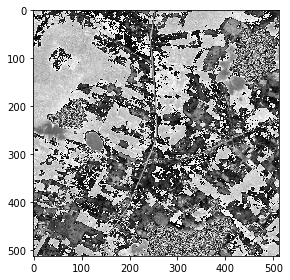

(446, 512, 512, 3)
(446, 512, 512, 1)


In [6]:
# Sanity Check
rand_idx = random.randrange(X_source.shape[0])
imshow(X_source[rand_idx,:,:,0], cmap='gray')
plt.show()
print(X_source.shape)
print(Y_label.shape)


In [7]:
#Use customary x_train and y_train variables
X_train = X_source
y_train = Y_label
print(X_train.shape)
print(y_train.shape)

(446, 512, 512, 3)
(446, 512, 512, 1)


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.85, random_state=42)

In [9]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [10]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [11]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(x_train)

In [12]:
features.shape

(66, 512, 512, 64)

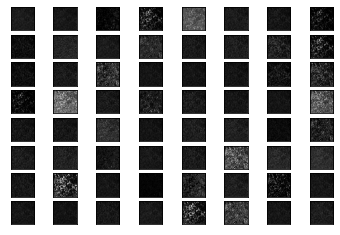

In [13]:
#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [14]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

In [15]:
X.shape

(17301504, 64)

In [16]:
#Reshape Y to match X
Y = y_train.reshape(-1)

In [17]:
#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())


[ 0  1 -1]
 0    14057495
-1     1688152
 1     1555857
Name: Label, dtype: int64


In [26]:
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != -1]

In [18]:
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

https://github.com/bnsreenu/python_for_microscopists/blob/master/159b_VGG16_imagenet_weights_RF_for_semantic.py

In [19]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 5, random_state = 42)

# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

RandomForestClassifier(n_estimators=5, random_state=42)

In [20]:
#Save model for future use
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

In [23]:
# Load a test image and calculate the features from VGG in order to be fed to random forest
test_img = imread(r'D:\\Thesis\\Data\\Sen1Floods11\\v1.1\\data\\flood_events\\HandLabeled\\S2Hand\\USA_430764_S2Hand.tif' ) #[:,:,IMG_CHANNELS]
new_image = np.transpose(test_img, (1, 2, 0))
test_img = new_image[:,:,1:4] # (446, 512, 512, 13)
test_img = np.expand_dims(test_img, axis=0)

X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

(1, 512, 512, 64)


In [30]:
# Use Trainned Random Forest for segmenting the test image
prediction = model.predict(X_test_feature)

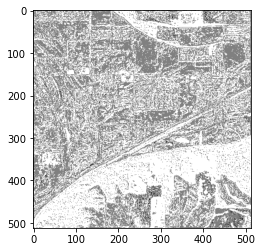

In [31]:
#View and Save segmented image
prediction_image = prediction.reshape(512,512)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('360_segmented.jpg', prediction_image, cmap='gray')

In [32]:
np.unique(prediction_image)

array([-1,  0,  1], dtype=int8)

https://www.youtube.com/watch?v=LsuCjbUoI7A&list=PLZsOBAyNTZwbIjGnolFydAN33gyyGP7lT&index=68&ab_channel=DigitalSreeni